
train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [788]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse

import warnings

warnings.filterwarnings("ignore")

In [789]:
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")
df_rent.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [790]:
df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [791]:
df.isna().sum()

ID                 0
area_type          0
availability       0
location           1
size              14
society         4428
total_sqft         0
bath              65
balcony          504
price              0
dtype: int64

## PRELIMINARY CLEAN-UPS

In [792]:
df.balcony.value_counts()

2.0    4069
1.0    3894
3.0    1342
0.0     847
Name: balcony, dtype: int64

<AxesSubplot:xlabel='size', ylabel='balcony'>

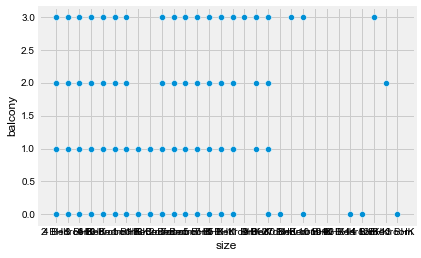

In [793]:
sns.scatterplot(x=df['size'], y=df.balcony)

In [794]:
df[df['balcony'].isna()]

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
6,6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
9,9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00
34,34,Built-up Area,Ready To Move,Kasturi Nagar,3 BHK,Kantsce,1925,3.0,NaN,125.00
40,40,Built-up Area,Ready To Move,Murugeshpalya,2 BHK,Gentson,1296,2.0,NaN,81.00
...,...,...,...,...,...,...,...,...,...,...
10560,10560,Built-up Area,Ready To Move,HSR Layout,5 Bedroom,NaN,4200,5.0,NaN,245.00
10561,10561,Super built-up Area,Ready To Move,Thubarahalli,3 BHK,Asnts a,1540,3.0,NaN,90.00
10593,10593,Built-up Area,Ready To Move,Marathahalli,4 Bedroom,Vemes H,3090,4.0,NaN,350.00
10634,10634,Plot Area,Immediate Possession,Rajankunte,NaN,NaN,1575,NaN,NaN,31.11


In [795]:
# Dropping the ID column for its redundancy
# Getting rid of society to avoid imputing huge amount of null values
# The value of balconies are absurd
# Availability doesnt much determine the price of a house
df.drop(columns=["ID", "availability", "society"], axis=1, inplace=True)

In [796]:
df = df.dropna(axis=0, subset=['size'])
df.isna().sum()

area_type       0
location        1
size            0
total_sqft      0
bath           51
balcony       490
price           0
dtype: int64

In [797]:
get_room_count = lambda x: int(str(x).split()[0]) if isinstance(x,str) else x

In [798]:
df['size']=df['size'].apply(get_room_count)
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00


In [799]:
from scipy import stats

df["balcony"].fillna(df.groupby('size')['balcony'].transform(lambda x: stats.mode(x)[0][0]), inplace=True)

In [800]:
df.isna().sum()

area_type      0
location       1
size           0
total_sqft     0
bath          51
balcony        2
price          0
dtype: int64

In [801]:
df.dropna(inplace=True)
df.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [802]:
df.shape

(10588, 7)

In [803]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00


In [804]:
df.head(10)

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00
5,Super built-up Area,Whitefield,2,1170,2.0,1.0,38.00
6,Super built-up Area,Old Airport Road,4,2732,4.0,2.0,204.00
7,Super built-up Area,Rajaji Nagar,4,3300,4.0,2.0,600.00
8,Super built-up Area,Marathahalli,3,1310,3.0,1.0,63.25
9,Plot Area,Gandhi Bazar,6,1020,6.0,2.0,370.00


In [805]:
ordinal_encoding_area_dict = {"Carpet  Area":0, "Built-up  Area":1, "Plot  Area":3, "Super built-up  Area":2}
df['area_type'] = df['area_type'].map(ordinal_encoding_area_dict)
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,2,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,3,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,1,Uttarahalli,3,1440,2.0,3.0,62.00
3,2,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,2,Kothanur,2,1200,2.0,1.0,51.00


In [806]:
df['size'].value_counts()

2     4426
3     3847
4     1117
1      531
5      280
6      175
7       77
8       68
9       48
10      10
11       4
27       1
43       1
12       1
13       1
14       1
Name: size, dtype: int64

In [807]:
# Finding all the rows in total_sqft which contain different units
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))
df.loc[df['total_sqft_is_alphanumeric']==True].head()

,area_type,location,size,total_sqft,bath,balcony,price,total_sqft_is_alphanumeric
410,2,Kengeri,1,34.46Sq. Meter,1.0,0.0,18.5,True
648,1,Arekere,9,4125Perch,9.0,3.0,265.0,True
775,1,Basavanagara,1,1000Sq. Meter,2.0,1.0,93.0,True
872,2,Singapura Village,2,1100Sq. Yards,2.0,1.0,45.0,True
1019,3,Marathi Layout,1,5.31Acres,1.0,0.0,110.0,True


We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [808]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)

In [809]:
df.drop(columns=["total_sqft_is_alphanumeric"], inplace=True)

### Adding per square-feet price

In [810]:
df['price_per_square_ft'] = (df['price']*1000000)/df['total_sqft']
df.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,2,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,3,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,2,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,2,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


### Finding all the unique Locations

In [811]:
df_1 = df[~(df['total_sqft']/df['size'] < 300)]
df_1.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,2,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,3,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,1,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,2,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,2,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


In [812]:
df_1.shape

(9985, 8)

In [813]:
# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>(m-st))& (subdf.price_per_square_ft<(m+st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df_2=remove_pps_outliers(df_1)
df_2.shape

(7214, 8)

Text(0, 0.5, 'Count')

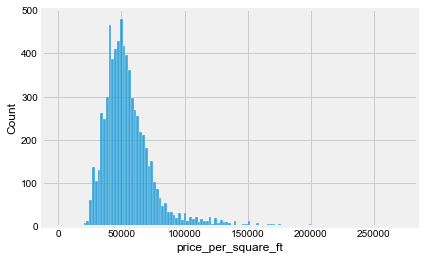

In [814]:
sns.histplot(df_2['price_per_square_ft'])
plt.ylabel('Count')

Text(0, 0.5, 'Count')

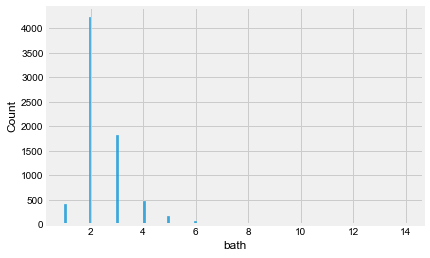

In [815]:
sns.histplot(df_2['bath'])
plt.ylabel('Count')

In [816]:
df_2.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,2,Devarabeesana Halli,3,1672.0,3.0,2.0,150.0,89712.918660
1,1,Devarabeesana Halli,3,1750.0,3.0,3.0,149.0,85142.857143
2,2,Devarabeesana Halli,3,1750.0,3.0,2.0,150.0,85714.285714
3,2,Devarachikkanahalli,3,1250.0,2.0,3.0,44.0,35200.000000
4,2,Devarachikkanahalli,2,1250.0,2.0,2.0,40.0,32000.000000


In [817]:
from sklearn import preprocessing

df_2_num = df_2.select_dtypes(include=np.number)
# Dropping the future target column from Scaling
df_2_num.drop(columns=['price'], inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df_2_num_scaled = min_max_scaler.fit_transform(df_2_num.values)
scaled_df = pd.DataFrame(df_2_num_scaled, columns=df_2_num.columns)
scaled_df.head()

,area_type,size,total_sqft,bath,balcony,price_per_square_ft
0,0.666667,0.222222,0.002101,0.153846,0.666667,0.330427
1,0.333333,0.222222,0.002220,0.153846,1.000000,0.313532
2,0.666667,0.222222,0.002220,0.153846,0.666667,0.315644
3,0.666667,0.222222,0.001455,0.076923,1.000000,0.128901
4,0.666667,0.111111,0.001455,0.076923,0.666667,0.117071


In [818]:
df_2_normalized = pd.concat([df_2.select_dtypes(exclude=np.number), scaled_df, df_2['price']], axis=1)
df_2_normalized.head()

,location,area_type,size,total_sqft,bath,balcony,price_per_square_ft,price
0,Devarabeesana Halli,0.666667,0.222222,0.002101,0.153846,0.666667,0.330427,150.0
1,Devarabeesana Halli,0.333333,0.222222,0.002220,0.153846,1.000000,0.313532,149.0
2,Devarabeesana Halli,0.666667,0.222222,0.002220,0.153846,0.666667,0.315644,150.0
3,Devarachikkanahalli,0.666667,0.222222,0.001455,0.076923,1.000000,0.128901,44.0
4,Devarachikkanahalli,0.666667,0.111111,0.001455,0.076923,0.666667,0.117071,40.0


In [878]:
df_2['location'] = df_2['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_test['location'] = df_test['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_rent['location'] = df_rent['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_dist['location'] = df_dist['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))

set_location_rent_data = set(df_rent['location'].unique())
set_location_dist_data = set(df_dist['location'].unique())
set_locations_train_data = set(df_2['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)
set_location_in_dist_rent_data = set_location_rent_data.intersection(set_location_dist_data)

In [879]:
print(len(set_location_in_dist_rent_data))

93


In [820]:
print(len(set_locations_train_data))

588


In [821]:
print(len(set_locations_test_data))

669


In [822]:
print(len(set_location_in_both_train_test_data))

438


In order to have the same number of columns in both train and test data, we need to set any location which is not present in both train and test data as other

In [823]:
# Setting the location which are rare as other
df_2['location'] = df_2['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

print(f"{len(df_2['location'].unique())} {len(df_2_normalized['location'].unique())}")

439 439


In [824]:
df_rent["location"] = df_rent["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_rent["location"].unique()).intersection(set_location_in_both_train_test_data))

88

In [825]:
df_dist["location"] = df_dist["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_dist["location"].unique()).intersection(set_location_in_both_train_test_data))

413

In [826]:
# Dummy encoding for location
dummies = pd.get_dummies(df_2['location'])
dummies_n = pd.get_dummies(df_2_normalized['location'])
dummies.head()

,1st block hrbr layout,1st block jayanagar,1st block koramangala,1st phase jp nagar,1st stage indira nagar,2nd block hrbr layout,2nd phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,3rd block banashankari,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [827]:
df_3 = pd.concat([df_2, dummies.drop(columns=["other"])], axis='columns')
df_3_n = pd.concat([df_2_normalized, dummies_n.drop(columns=["other"])], axis='columns')
df_3.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft,1st block hrbr layout,1st block jayanagar,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,2,devarabeesana halli,3,1672.0,3.0,2.0,150.0,89712.918660,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,devarabeesana halli,3,1750.0,3.0,3.0,149.0,85142.857143,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,devarabeesana halli,3,1750.0,3.0,2.0,150.0,85714.285714,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,devarachikkanahalli,3,1250.0,2.0,3.0,44.0,35200.000000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,devarachikkanahalli,2,1250.0,2.0,2.0,40.0,32000.000000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [828]:
df_3.drop(columns=['location'], inplace=True)
df_3_n.drop(columns=['location'], inplace=True)

In [829]:
X=df_3.drop('price', axis='columns')
X_n=df_3_n.drop('price', axis='columns')
X.head()

,area_type,size,total_sqft,bath,balcony,price_per_square_ft,1st block hrbr layout,1st block jayanagar,1st block koramangala,1st phase jp nagar,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,2,3,1672.0,3.0,2.0,89712.918660,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,1750.0,3.0,3.0,85142.857143,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,1750.0,3.0,2.0,85714.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,3,1250.0,2.0,3.0,35200.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,1250.0,2.0,2.0,32000.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [830]:
y = df_3['price']
y_n = df_3_n['price']

#### Using Non-Normalized Columns

In [831]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

model_1=LinearRegression()
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

-2535924498878.095

In [832]:
rmse(model_1.predict(X), y)

67177858.32371895

#### Using Normalized Columns

In [833]:
# Linear Regression using normalized columns
X_train,X_test,y_train,y_test=train_test_split(X_n,y_n,test_size=0.2)

model_2=LinearRegression()
model_2.fit(X_train,y_train)
model_2.score(X_test,y_test)

-3.062273602252866e+23

In [834]:
rmse(model_2.predict(X_n), y_n)

27414576073081.117

#### Dropping the price_per_square_ft column

In [835]:
# This column need to be dropped as it uses the target variable to calculate
X_1 = X.drop(columns=["price_per_square_ft"])
X_n_1 = X_n.drop(columns=["price_per_square_ft"])
X_1.shape

(7214, 443)

#### Using non-normalized columns

In [836]:
X_train,X_test,y_train,y_test=train_test_split(X_1,y,test_size=0.2)

model_3=LinearRegression()
model_3.fit(X_train,y_train)
model_3.score(X_test,y_test)

-10203205477167.58

#### Using normalized columns

In [837]:
X_train,X_test,y_train,y_test=train_test_split(X_n_1,y_n,test_size=0.2)

model_4=LinearRegression()
model_4.fit(X_train,y_train)
model_4.score(X_test,y_test)

-4.576047252849346e+24

In [838]:
X_n_1.head()

,area_type,size,total_sqft,bath,balcony,1st block hrbr layout,1st block jayanagar,1st block koramangala,1st phase jp nagar,1st stage indira nagar,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,0.666667,0.222222,0.002101,0.153846,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.333333,0.222222,0.002220,0.153846,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.666667,0.222222,0.002220,0.153846,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.666667,0.222222,0.001455,0.076923,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.666667,0.111111,0.001455,0.076923,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [839]:
X_2 = X_1.drop(columns=["area_type", "size"])

In [840]:
X_train,X_test,y_train,y_test=train_test_split(X_2,y,test_size=0.2)

model=LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

-689330784077216.2

In [841]:
# Cross validation
score = cross_val_score(model,X_1,y,cv=5,scoring='r2')

avg_score=score.mean()
coeff_of_variance = score.std()/score.mean()
coeff_of_variance

-2.011989804478237

In [842]:


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        y_pred=gs.predict(X)
        gs_rmse = rmse(y,y_pred)
        scores.append({
            'model': algo_name,
            'shape': X.shape,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'rmse': gs_rmse
        })

    return pd.DataFrame(scores,columns=['model','shape', 'best_score','best_params','rmse'])

find_best_model_using_gridsearchcv(X_1,y)


,model,shape,best_score,best_params,rmse
0,linear_regression,"(7214, 443)",-3.034236e+13,{'normalize': False},61.891753
1,lasso,"(7214, 443)",-2.474946e+01,"{'alpha': 1, 'selection': 'cyclic'}",86.591050
2,decision_tree,"(7214, 443)",5.582329e-01,"{'criterion': 'friedman_mse', 'splitter': 'ran...",3.100569


In [843]:
X_1.shape

(7214, 443)

In [844]:
res_df = pd.DataFrame(columns=['model','best_score','best_params','rmse'])
# Creating the best model separately

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
gs =  GridSearchCV(
    DecisionTreeRegressor(), 
    {
        'criterion' : ['mse','friedman_mse'],
        'splitter': ['best','random']
    },
    cv=cv, 
    return_train_score=False
)
gs.fit(X_1,y)

y_pred=gs.predict(X_1)
gs_rmse = rmse(y,y_pred)
res_df.append({
    "model": "DecisionTreeRegressor",
    "best_score": gs.best_score_,
    "best_params": gs.best_params_,
    "rmse": gs_rmse
}, ignore_index=True)
print(y_pred[:20])
print(y[:20])

[150.   149.   150.    44.    40.    83.    40.    65.    43.    36.
  76.    58.    75.    47.    40.    70.    28.    25.25  25.25  80.  ]
0     150.00
1     149.00
2     150.00
3      44.00
4      40.00
5      83.00
6      40.00
7      65.00
8      43.00
9      36.00
10     76.00
11     58.00
12     75.00
13     47.00
14     40.00
15     70.00
16     28.00
17     25.25
18     25.25
19     80.00
Name: price, dtype: float64


In [845]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0,0.1,1,2], 'l1_ratio':[0.000001, 0.001, 0.155, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.999, 1]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X_1, y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_}")

Best Hyper Parameter: {'alpha': 0.1, 'l1_ratio': 0.8}
Best Score: 0.0020317202799062795


In [846]:
enet_rmse = rmse(enet_model.predict(X_1),y)
enet_rmse

104.71823648024052

In [847]:
from sklearn.ensemble import RandomForestRegressor

x_train,x_test,y_train,y_test=train_test_split(X_1,y, test_size=0.25)
RFC = RandomForestRegressor(n_estimators=75, n_jobs=-1, oob_score=True, random_state=10)
RFC.fit(x_train,y_train)
y_test_pred = RFC.predict(x_test)
rmse(y_test, y_test_pred)

80.32120933531375

In [848]:
from sklearn.model_selection import GridSearchCV

x=X_1

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.05,random_state=10)

param={'max_depth':[5,10,15,20,30],'min_samples_leaf':[10,15,20,50,100]}

gs_rfc=GridSearchCV(estimator=RFC,param_grid=param,cv=4,n_jobs=-1,scoring='r2')

gs_rfc.fit(x_train,y_train)

gs_rfc.best_estimator_
gs_best=gs_rfc.best_estimator_

gs_best.fit(x_train,y_train)

train_pred=gs_best.predict(x_train)

test_pred=gs_best.predict(x_test)


print('RMSE for train:',np.sqrt(mean_squared_error(y_train,train_pred)))
print('RMSE for test:',np.sqrt(mean_squared_error(y_test,test_pred)))


print('r2_score for train:',r2_score(y_train,train_pred))
print('r2_score for test:',r2_score(y_test,test_pred))

RMSE for train: 56.7329091166813
RMSE for test: 40.17615338943825
r2_score for train: 0.7169067406759722
r2_score for test: 0.7038883592803153


## PROCESSING THE TEST-DATA

In [849]:
df_test.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th phase jp nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,tc palaya,1 Bedroom,NaN,1350,1.0,0.0


In [850]:
df_test.columns

Index(['ID', 'area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony'],
      dtype='object')

In [851]:
df_test_1 = df_test.drop(columns=["ID", "availability", "society"])
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2 BHK,650,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3 BHK,1370,2.0,1.0
2,Super built-up Area,whitefield,3 BHK,1725,3.0,2.0
3,Built-up Area,jalahalli,2 BHK,1000,2.0,0.0
4,Plot Area,tc palaya,1 Bedroom,1350,1.0,0.0


In [852]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2 BHK,650,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3 BHK,1370,2.0,1.0
2,Super built-up Area,whitefield,3 BHK,1725,3.0,2.0
3,Built-up Area,jalahalli,2 BHK,1000,2.0,0.0
4,Plot Area,tc palaya,1 Bedroom,1350,1.0,0.0


In [853]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [854]:
df_test_1['size'].fillna(df_test_1['total_sqft']//300, inplace=True)

In [855]:
df_test_1['size']=df_test_1['size'].apply(get_room_count)
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650.0,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725.0,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000.0,2.0,0.0
4,Plot Area,tc palaya,1.0,1350.0,1.0,0.0


In [856]:
df_test_1["balcony"].fillna(df_test_1.groupby('size')['balcony'].transform(lambda x: stats.mode(x)[0][0]), inplace=True)


In [857]:
df_test_1["balcony"].fillna(0, inplace=True)

In [858]:
df_test_1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          8
balcony       0
dtype: int64

<AxesSubplot:xlabel='size', ylabel='bath'>

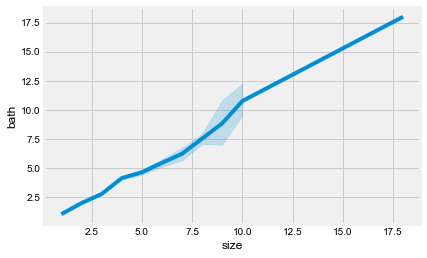

In [859]:
sns.lineplot(x=df_test_1['size'], y=df_test_1['bath'])

In [860]:
df_test_1[df_test_1['bath'].isna()]

,area_type,location,size,total_sqft,bath,balcony
70,Super built-up Area,sarjapur road,3.0,1773.5,NaN,2.0
363,Plot Area,yelahanka,5.0,1500.0,NaN,2.0
641,Super built-up Area,hennur,4.0,3517.0,NaN,2.0
840,Super built-up Area,kanakpura road,1.0,525.0,NaN,1.0
913,Plot Area,hosur road,4.0,1350.0,NaN,2.0
2112,Built-up Area,bettahalsoor,5.0,3210.0,NaN,2.0
2205,Super built-up Area,kr puram,4.0,2283.0,NaN,2.0
2584,Super built-up Area,devanahalli,1.0,1075.0,NaN,1.0


As per the line-plot, the number of baths is equal to number of rooms.

In [861]:
df_test_1['bath'].fillna(df_test_1['size'], inplace=True)

In [862]:
df_test_1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
dtype: int64

In [863]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650.0,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725.0,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000.0,2.0,0.0
4,Plot Area,tc palaya,1.0,1350.0,1.0,0.0


In [864]:
df_test_1['area_type']=df_test_1['area_type'].map(ordinal_encoding_area_dict)

In [865]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,2,chamrajpet,2.0,650.0,1.0,1.0
1,2,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,2,whitefield,3.0,1725.0,3.0,2.0
3,1,jalahalli,2.0,1000.0,2.0,0.0
4,3,tc palaya,1.0,1350.0,1.0,0.0


In [866]:
len(df_test_1['location'].unique())

669

In [867]:
df_test_1['location'] = df_test_1['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

# df_test_1['location'] = df_test_1['location'].apply(lambda x: 'other' if x in location_less_than_ten else x)
len(df_test_1['location'].unique())

439

In [868]:
dummies = pd.get_dummies(df_test_1['location'])
dummies.head()

,1st block hrbr layout,1st block jayanagar,1st block koramangala,1st phase jp nagar,1st stage indira nagar,2nd block hrbr layout,2nd phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,3rd block banashankari,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [869]:
df_test_2 = pd.concat([df_test_1, dummies.drop(columns=["other"])], axis='columns')
df_test_2.head()

,area_type,location,size,total_sqft,bath,balcony,1st block hrbr layout,1st block jayanagar,1st block koramangala,1st phase jp nagar,...,volagerekallahalli,whitefield,wilson garden,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yemlur,yeshwanthpur,yeshwanthpur industrial suburb
0,2,chamrajpet,2.0,650.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,7th phase jp nagar,3.0,1370.0,2.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,whitefield,3.0,1725.0,3.0,2.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,1,jalahalli,2.0,1000.0,2.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,tc palaya,1.0,1350.0,1.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [870]:
df_test_3 = df_test_2.drop(columns=["location"])

In [871]:
df_test_3.shape

(2664, 443)

In [872]:
y_test_pred = gs.predict(df_test_3)
y_test_pred

array([ 25.  ,  95.  ,  95.  , ...,  38.37, 420.  ,  17.  ])

In [873]:
df_sol = pd.DataFrame()
df_sol['price'] = y_test_pred
df_sol.index.name='ID'
df_sol.head()

,price
ID,
0,25.0
1,95.0
2,95.0
3,52.0
4,175.0


In [874]:
df_sol.to_csv("sol_gs.csv")

### Using ElasticNet

In [875]:
y_pred_enet = enet_model.predict(df_test_3)
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.to_csv("sol_enet.csv")

### Using Random Forest

In [876]:
y_pred_RFC = RFC.predict(df_test_3)
df_sol_RFC = pd.DataFrame()
df_sol_RFC['price'] = y_pred_enet
df_sol_RFC.index.name='ID'
df_sol_RFC.to_csv("sol_RFC.csv")

### Using GridSearch CV on Random Forest

In [877]:
y_pred_GS_CV = gs_best.predict(df_test_3)
df_sol_GS_CV = pd.DataFrame()
df_sol_GS_CV['price'] = y_pred_GS_CV
df_sol_GS_CV.index.name='ID'
df_sol_GS_CV.to_csv("sol_GS_CV.csv")